# Modeling infectious disesase spread
I am attempting to learn how to model the spread of infectious diseases using SIR and SEIR models. The tutorials I am using are the articles beginning [here](https://towardsdatascience.com/infectious-disease-modelling-part-i-understanding-sir-28d60e29fdfc). A good article about the mathematics of infectious disease spread modeling is [Hethcote 2000](http://www.maths.usyd.edu.au/u/marym/populations/hethcote.pdf).

## Compartmental mdoel - start with three compartments
Fit everyone into one of 3 buckets - **S**usceptible, **I**nfected, **R**ecovered.

First, let's set up some notation:

* Let $N$ be the initial population
* Let $S(t)$ denote the number of susceptible persons at time $t$
* Let $I(t)$ denote the number of infected persons at time $t$
* Let $R(t)$ denote the number of recovered persons at time $t$
* Let $t_{0}$ be a fixed point in time such that $S(t_{0})$ is known in advance
* Let $D$ be the number of days during which an infected person can infect people - there's a word for this but I can't think of what it is
* Let $\beta$ denote the number of people that can be infected by an infected person each day.
* Let $R_{0}$ be the number of people that an infected person can infect. Due to COVID-19 this concept and nomenclature is now well-known to many. We thus have $R_{0}$ = $\beta \times D$.
* Let $\gamma$ be the rate of recovery - the proportion of infected recovering per day. We have $\gamma = \frac{1}{D}$. From this it follows that $R_{0} = \frac{\beta}{\gamma}$.

### The model

We'll follow up with an example. We look at the changes in each of the three compartments over time.

**WARNING!!!** There is a major assumption here - which is that recovered persons do not rejoin the susceptible compartment. If you happen to be thinking of COVID-19 right now - there is [evidence](https://www.the-scientist.com/news-opinion/studies-report-rapid-loss-of-covid-19-antibodies-67650) that this may not be the case.

**Susceptible**: The change in susceptible persons is just saying of the people available to be infected, these people actually were. This is 

$$ \frac{dS}{dt} = -I(t) \times \beta \times \frac{S(t)}{N} $$

In plain language, it's saying that people were moved out of the susceptible compartment and into the infected compartment. The probability of an infected person meeting a susceptible person is $S(t)/N$, and the rate of infection is $\beta$ per day.

**Infected**: The change in infected persons over time is thus

$$ \frac{dI}{dt} = \beta I(t) \frac{S(t)}{N} - \gamma I(t) $$

The first part we already worked out - the second term is the recovered people, which is the people available to recover (the infected) times the rate of recovery.

**Recovered**: The change in recovered people is just

$$ \frac{dR}{dt} = \gamma I(t) $$

*Voila* - we have a set of ordinary differential equations.

### Needed libraries

In [4]:
import numpy as np
from scipy import integrate as si
import matplotlib.pyplot as plt

### A hard example
Let's do the example from the text with made up parameters.

In [5]:
N = 1000 #start with a state of 1000 people
beta = 1.0 #each infected person infects one other person per day
D = 4 #each infection lasts four days
gamma = 1.0 / D
# See here that R0 = beta x D = 4.0. That disease is very virulent

S0, I0, R0 = 999,1,0 # Start with 1 infection, and the rest are susceptible.

In [6]:
# implement the formulae above
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = - beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [7]:
t = np.linspace(0, 50, 50)
y0 = S0, I0, R0
ret = si.odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

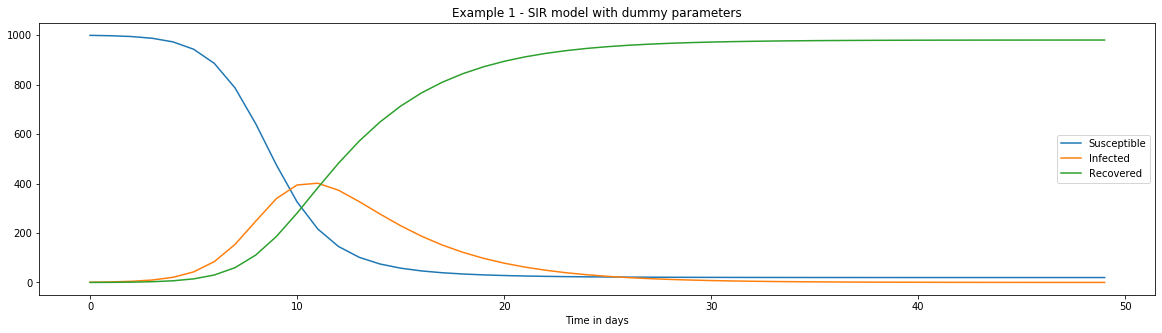

In [8]:
# Plot it
fig = plt.figure(figsize=(20,5))
plt.plot(S, label='Susceptible')
plt.plot(I, label='Infected')
plt.plot(R, label='Recovered')
plt.legend()
plt.title("Example 1 - SIR model with dummy parameters")
plt.xlabel("Time in days")
plt.show()

Let's change just one initial condition - set $\beta$ to 0.5 - and see what happens.

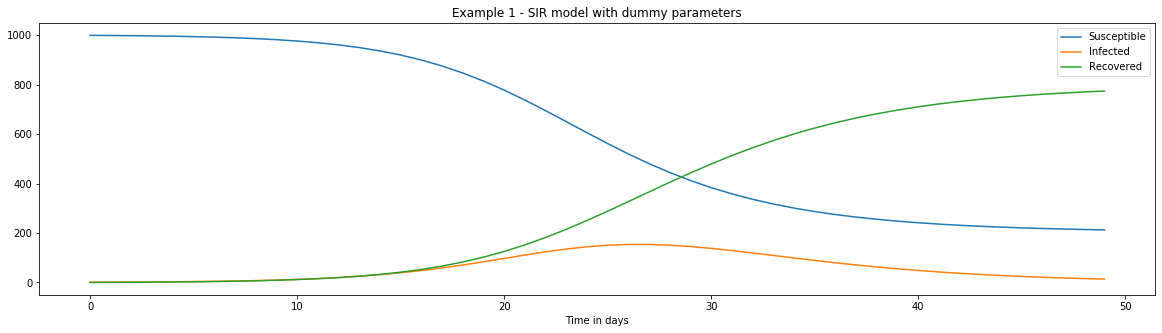

In [9]:
beta = 0.5
ret2 = si.odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret2.T
fig = plt.figure(figsize=(20,5))
plt.plot(S, label='Susceptible')
plt.plot(I, label='Infected')
plt.plot(R, label='Recovered')
plt.legend()
plt.title("Example 1 - SIR model with dummy parameters")
plt.xlabel("Time in days")
plt.show()

That's a big change. Thus it appears that the model is highly dependent on the initial conditions.

## Extending the model
It may be helpful to think of the equations as transitions between the compartments. Later on I'll draw up a graphic that illustrates these. The transitions each contain three components - rate of transition, probability of transition, and population available to make the transition. Intruduce a new paramter $\delta$, the rate at which exposed people contract the disease.

### The exposed compartment

Now we are going to add an **E**xposed compartment (making our SIR model into a SEIR model). The transitions are then: $ S \rightarrow E \rightarrow  I \rightarrow  R$.

This new model is equivalent to the first one if you assume that all susceptible people are immediately exposed, and all exposed people become infected, with all other things being equal. Then the system of equations becomes

$$ \frac{dS}{dt} = -I(t) \times \beta \times \frac{S(t)}{N} $$

$$ \frac{dE}{dt} = \beta I(t) \frac{S(t)}{N} - \delta E(t) $$

$$ \frac{dI}{dt} = \delta E(t) - \gamma I(t) $$

$$ \frac{dR}{dt} = \gamma I(t) $$

In plain English, the exposed people each turn are increased by (some proportion, in this case 100% of) the number of susceptible people that come into contact with the disease, and is reduced each turn by the number of exposed people that contract the disease. The infected people each turn are in turn increased by that amount and decreased by the people that recovered (presently the only possible state after infection). The recovered increase by that amount as well. We need to implement a new system of equations:

In [17]:
def derivSEIR(y, t, N, beta, gamma, delta):
    S,E,I,R = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - delta * E
    dIdt = delta * E - gamma * I
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt

In [18]:
N = 1000
beta = 1.0 # each infected person infects an average of 1 other person each day they are infectious
D = 4.0 # infections last 4 days
gamma = 1.0 / D 
delta = 1.0 / 3.0 # incubation period of 3 days

S0, E0, I0, R0 = 999, 1, 0, 0 # initial conditions - 1 exposed, all others susceptible

In [19]:
t = np.linspace(0, 100, 100) # Time points in days
y0 = S0, E0, I0, R0 # vectorized initial conditions

In [20]:
#Integrate over T
retSEIR = si.odeint(derivSEIR, y0, t, args=(N, beta, gamma, delta))
S,E,I,R = retSEIR.T

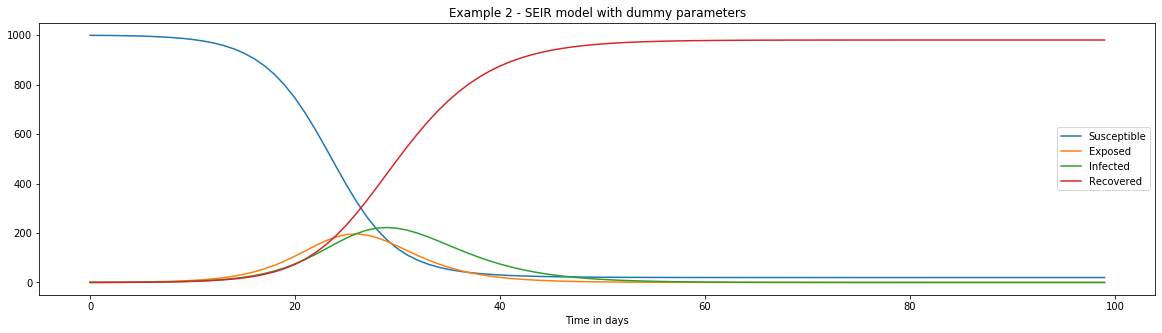

In [21]:
fig = plt.figure(figsize=(20,5))
plt.plot(S, label='Susceptible')
plt.plot(E, label='Exposed')
plt.plot(I, label='Infected')
plt.plot(R, label='Recovered')
plt.legend()
plt.title("Example 2 - SEIR model with dummy parameters")
plt.xlabel("Time in days")
plt.show()

## Extending the model 2 - I see dead people
Deaths split off from the infected stage. Let us denote the death rate by $\alpha \in [0,1]$. Let us also denote the time rate at which infected people die by $\rho$. If it takes 5 days to die once infected, then $\rho =$ 1 per 5 days. This means the new probability for the $I \rightarrow R$ transition is $1 - \alpha$.

Now we have 5 equations:

$$ \frac{dS}{dt} = -I(t) \times \beta \times \frac{S(t)}{N} $$

$$ \frac{dE}{dt} = \beta I(t) \frac{S(t)}{N} - \delta E(t) $$

$$ \frac{dI}{dt} = \delta E(t) - (1 - \alpha) \gamma I(t) - \alpha \rho I(t)$$

$$ \frac{dR}{dt} = (1 - \alpha) \gamma I(t) $$

$$ \frac{dD}{dt} = \alpha \rho I(t) $$

In [27]:
def derivSEIRD(y, t, N, beta, gamma, delta, alpha, rho):
    S,E,I,R,D = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

In [28]:
N = 1000000
D = 4.0 # infections lasts four days
gamma = 1.0 / D
delta = 1.0 / 5.0  # incubation period of five days
R_0 = 5.0
beta = R_0 * gamma  # R_0 = beta / gamma, so beta = R_0 * gamma
alpha = 0.2  # 10% death rate
rho = 1/9  # 9 days from infection until death
S0, E0, I0, R0, D0 = N-1, 1, 0, 0, 0  # initial conditions: one exposed

In [29]:
t = np.linspace(0, 100, 100) # Grid of time points (in days)
y0 = S0, E0, I0, R0, D0 # Initial conditions vector

# Integrate the SIR equations over the time grid, t.
retSEIRD = si.odeint(derivSEIRD, y0, t, args=(N, beta, gamma, delta, alpha, rho))
S, E, I, R, D = retSEIRD.T

In [61]:
def plotseird(t, S, E, I, R, D, title="UNTITLED", titlesize=18):
  f, ax = plt.subplots(1,1,figsize=(20,7))
  ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
  ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
  ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
  ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
  ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
  ax.plot(t, S+E+I+R+D, 'c--', alpha=0.7, linewidth=2, label='Total')

  ax.set_xlabel('Time (days)')

  ax.yaxis.set_tick_params(length=0)
  ax.xaxis.set_tick_params(length=0)
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')
  legend = ax.legend()
  legend.get_frame().set_alpha(0.5)
  for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)
  plt.title(title, size=titlesize)
  plt.show();

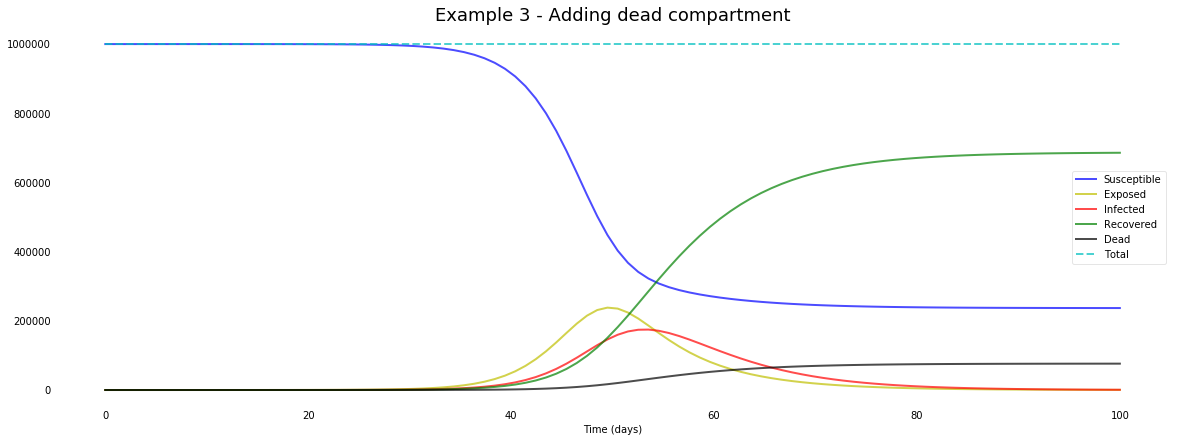

In [63]:
plotseird(t,S,E,I,R,D, "Example 3 - Adding dead compartment")

## Extending the model 3: Time dependent $R_{0}$

In fact, $R_{0}$ changes over time. This is apparently typically done with a logistic function with three parameters:

* $R_{0}(t_{0})$ = the value of $R_{0}$ at time t
* $R_{0}(t_{0} + x)$  = the value of $R_{0}$ at time t+x
* $k$ - rate of logistic change

so that in the time interval $[t, t+x]$, we have $R_{0}(t)$ changing smoothly from $R_{0}(t_{0})$ to $R_{0}(t_{0} + x)$. The parameter $k$ sets the rate of change.

In [42]:
k = np.linspace(0.1,1,9)
t = np.linspace(0,100,100)
def logistic(x_st, x_end, t, t0, k):
    return ((x_st - x_end) / (1 + np.exp(-k * (-t+t0)))) + x_end

In [43]:
y1 = logistic(2.0, 1.4, t=t, t0 = 50, k=0.1)
y2 = logistic(2.0, 1.4, t=t, t0 = 50, k=0.5)
y3 = logistic(2.0, 1.4, t=t, t0 = 50, k=1.0)

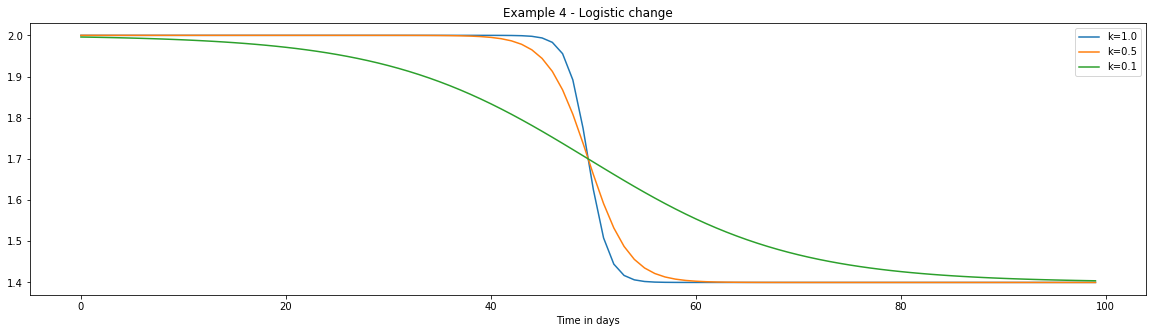

In [64]:
fig = plt.figure(figsize=(20,5))
plt.plot(y3, label='k=1.0')
plt.plot(y2, label='k=0.5')
plt.plot(y1, label='k=0.1')
plt.legend()
plt.title("Example 4 - Logistic change")
plt.xlabel("Time in days")
plt.show()

In [45]:
def deriv(y, t, N, beta, gamma, delta, alpha, rho):
    S, E, I, R, D = y
    dSdt = -beta(t) * S * I / N
    dEdt = beta(t) * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

In [46]:
N = 1_000_000
D = 4.0 # infections lasts four days
gamma = 1.0 / D
delta = 1.0 / 5.0  # incubation period of five days

R_0_start, k, x0, R_0_end = 5.0, 0.5, 50, 0.5

def logistic_R_0(t):
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

def beta(t):
    return logistic_R_0(t) * gamma

alpha = 0.2  # 20% death rate
rho = 1/9  # 9 days from infection until death
S0, E0, I0, R0, D0 = N-1, 1, 0, 0, 0  # initial conditions: one exposed

In [49]:
t = np.linspace(0, 100, 100) # Grid of time points (in days)
y0 = S0, E0, I0, R0, D0 # Initial conditions vector

# Integrate the SIR equations over the time grid, t.
ret = si.odeint(deriv, y0, t, args=(N, beta, gamma, delta, alpha, rho))
S, E, I, R, D = ret.T
R0_over_time = [logistic_R_0(i) for i in range(len(t))]  # to plot R_0 over time: get function values

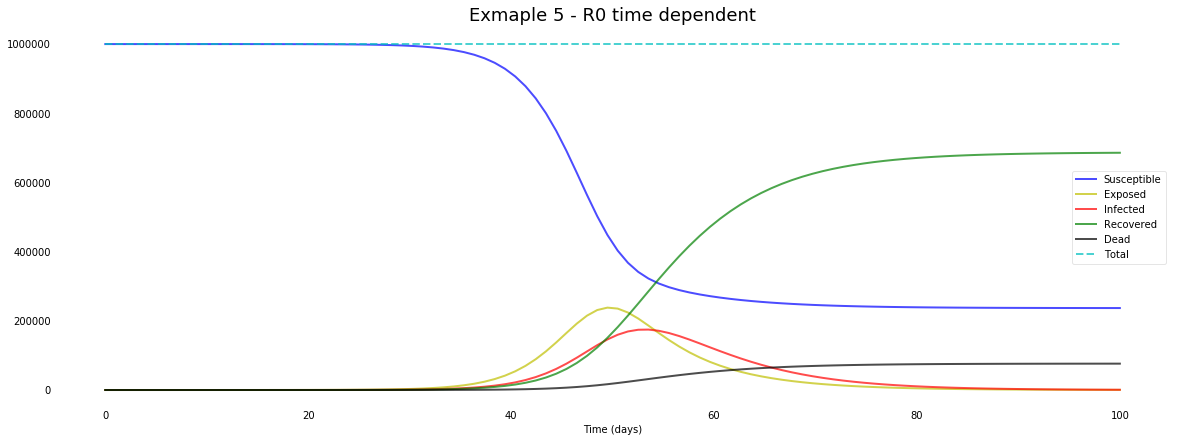

In [65]:
plotseird(t,S,E,I,R,D, "Exmaple 5 - R0 time dependent")

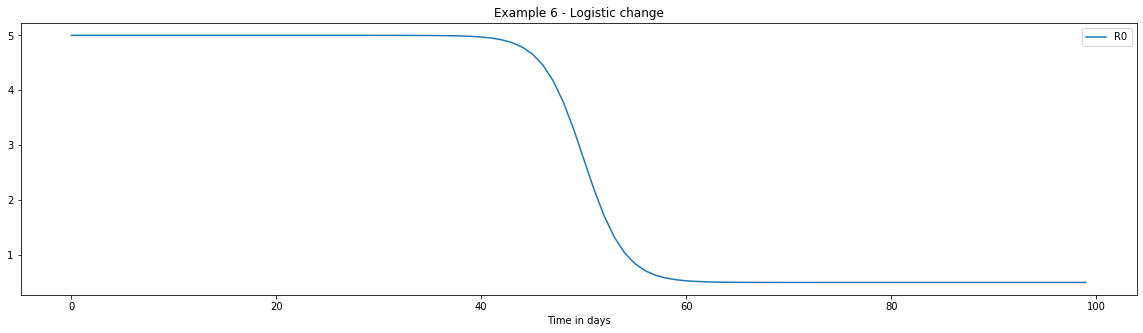

In [66]:
fig = plt.figure(figsize=(20,5))
plt.plot(R0_over_time, label='R0')
plt.legend()
plt.title("Example 6 - Logistic change")
plt.xlabel("Time in days")
plt.show()

## Extending the model 4 - Resource and age dependent fatailty rates
It seems obvious that $\alpha$ should depend on a few things at least. For one, if more people are infected, the resources available to care for the infected are fewer and thus receive sub-optimal treatment. One way to do this is to say something like

$$ \alpha(t) = s \frac{I(t)}{N} + \alpha_{OPT} $$

where $\alpha_{OPT}$ is the death rate under ideal care and $s \in [0,1]$ is the weight applied to the penalty for sub-optimal care. One might also consider adjusting this for the beds, ICU beds, or ventilators available. 

**Age:** To do this perfectly you'd need a set of compartments for every age group, and that is a pain. I haven't reviewed how YYG or anyone else deals with this. One way is as follows:

In [67]:
alpha_by_agegroup = {
    "0-29": 0.01, "30-59": 0.05, "60-89": 0.20, "89+": 0.30
} # age-related death rate
proportion_of_agegroup = {
    "0-29": 0.1, "30-59": 0.3, "60-89": 0.4, "89+": 0.2
} # population split

In [68]:
alpha = sum(alpha_by_agegroup[i] * proportion_of_agegroup[i] 
            for i in list(alpha_by_agegroup.keys())) # The sumproduct of two dicts

In [69]:
def deriv(y, t, N, beta, gamma, delta, alpha_opt, rho):
    S, E, I, R, D = y
    def alpha(t):
        return s * I/N + alpha_opt

    dSdt = -beta(t) * S * I / N
    dEdt = beta(t) * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha(t)) * gamma * I - alpha(t) * rho * I
    dRdt = (1 - alpha(t)) * gamma * I
    dDdt = alpha(t) * rho * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

In [70]:
N = 1_000_000
D = 4.0 # infections lasts four days
gamma = 1.0 / D
delta = 1.0 / 5.0  # incubation period of five days

R_0_start, k, x0, R_0_end = 5.0, 0.5, 50, 0.5

def logistic_R_0(t):
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

def beta(t):
    return logistic_R_0(t) * gamma

alpha_by_agegroup = {"0-29": 0.01, "30-59": 0.05, "60-89": 0.2, "89+": 0.3}
proportion_of_agegroup = {"0-29": 0.1, "30-59": 0.3, "60-89": 0.4, "89+": 0.2}
s = 1.0
alpha_opt = sum(alpha_by_agegroup[i] * proportion_of_agegroup[i] for i in list(alpha_by_agegroup.keys()))

rho = 1/9  # 9 days from infection until death
S0, E0, I0, R0, D0 = N-1, 1, 0, 0, 0  # initial conditions: one exposed

In [72]:
t = np.linspace(0, 100, 100) # Grid of time points (in days)
y0 = S0, E0, I0, R0, D0 # Initial conditions vector

# Integrate the SIR equations over the time grid, t.
ret = si.odeint(deriv, y0, t, args=(N, beta, gamma, delta, alpha_opt, rho))
S, E, I, R, D = ret.T
R0_over_time = [logistic_R_0(i) for i in range(len(t))]  # to plot R_0 over time: get function values
Alpha_over_time = [s * I[i]/N + alpha_opt for i in range(len(t))]  # to plot alpha over time

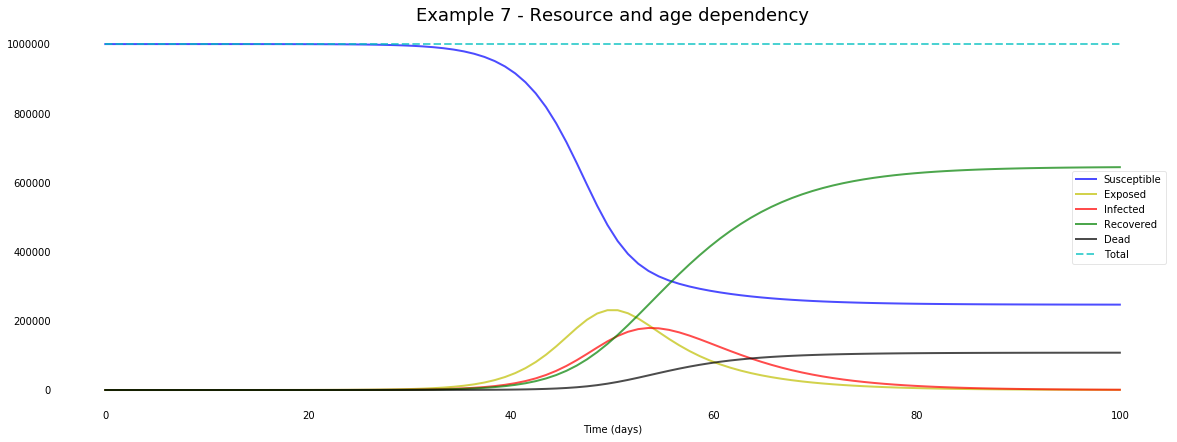

In [73]:
plotseird(t, S, E, I, R, D, title='Example 7 - Resource and age dependency')